In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns
import re
from datetime import date, datetime
import glob
import plotly.figure_factory as ff
from scipy.spatial import distance
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.animation import FuncAnimation
from scipy.spatial import distance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import kerastuner as kt
import statistics as st

path = "data"

In [2]:
#Let's just import week1 so that we can move quickly. Later on we can import all the data.s
#all_files = glob.glob(path + "/*.csv")
#li = []

#for filename in all_files:
#    df = pd.read_csv(filename, index_col=None, header=0)
#    li.append(df)

#week1 = pd.concat(li, axis=0, ignore_index=True)
week1 = pd.read_csv(path + "/week1.csv")

In [3]:
week1.shape

(986022, 19)

In [4]:
#li = []
#df1 = pd.read_csv(path + "/week1.csv")
#df2 = pd.read_csv(path + "/week2.csv")
#df3 = pd.read_csv(path + "/week3.csv")
#df4 = pd.read_csv(path + "/week4.csv")
#df5 = pd.read_csv(path + "/week5.csv")
#df6 = pd.read_csv(path + "/week6.csv")

In [5]:
#li.append(df1)
#li.append(df2)
#li.append(df3)
#li.append(df4)
#li.append(df5)
#li.append(df6)

In [6]:
#week1 = pd.concat(li, axis=0, ignore_index=True)

In [7]:
def plot_voronoi(df, gameid, playid, frameid):
    away = df[(df['gameId'] == gameid)&(df['team'] == 'away')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    home = df[(df['gameId'] == gameid)&(df['team'] == 'home')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    ball = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    ball_start = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(df['event'] == 'ball_snap')]
    
    homex = home.loc[:, 'x']
    homey = home.loc[:, 'y']
    
    awayx = away.loc[:, 'x']
    awayy = away.loc[:, 'y']

    ballx = ball.loc[:, 'x']
    bally = ball.loc[:, 'y']
    
    ballstartx = ball_start.loc[:, 'x']
    
    #We subtract 10 from each of our x measurements to obtain the actual yards to each endzone
    points = [[x-10, y] for x, y in zip(homex, homey)]
    points.extend([[x-10, y] for x, y, in zip(awayx, awayy)])
    #points.extend([[x, y] for x, y, in zip(ballx, bally)])

    v = Voronoi(points)
    voronoi_plot_2d(v)
    
    plt.scatter(homex-10, homey, color = 'r', label = 'home')
    plt.scatter(awayx-10, awayy, color = 'b', label = 'away')
    plt.scatter(ballx-10, bally, color = 'g', label = 'football')
    plt.axvline(x=ballstartx.values-10, color = "k", linewidth = 0.5)
    plt.axhline(y = 53.3, color = "k", linewidth = 1)
    plt.axhline(y = 0, color = "k", linewidth = 1)
    plt.axvline(x= 100, color = "r", linewidth = 0.5)
    plt.axvline(x= 110, color = "r", linewidth = 0.5)
    plt.ylim((-2, 55))
    plt.legend()
    plt.show()

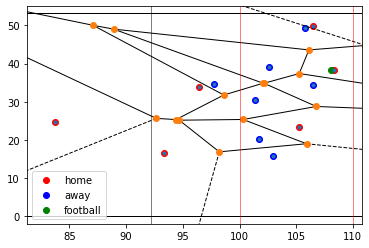

In [8]:
plot_voronoi(week1, 2018090900, 947, 47)

In [9]:
#Create additional column on week1 for a unique identifier of gameId and playId
week1['gp'] = week1['gameId'].astype(str)+ '_' + week1['playId'].astype(str)

In [10]:
#Create temp df for only QBs. We know QBs are always attacking so we will knnow what game/play/team combination
#corresponds to players that are attacking
qbs = week1[(week1['event'] == 'pass_forward')&(week1['position'] == 'QB')]

In [11]:
#We drop all columns except team, gp, our QB's x and y coordinates which are the ones were interested in
qbs.drop(qbs.columns.difference(['team','gp', 'x', 'y']), 1, inplace=True)

In [12]:
#We drop duplicates, as we don't really need the same information for each frame
qbs.drop_duplicates(subset=['gp'], inplace = True)

In [13]:
football = week1[(week1['displayName'] == 'Football') & (week1['event'].isin(['pass_outcome_touchdown', 'pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception']))]

In [14]:
football.drop(football.columns.difference(['gp', 'x', 'y']), 1, inplace=True)

In [15]:
week1 = week1.merge(football, on = 'gp', suffixes=('', '_football'))

In [16]:
#We merge our qbs data frame with our week1 dataframe based on game/play id
week1 = week1.merge(qbs, on ="gp", suffixes=('', '_qb_pass_forward'))

In [17]:
#We create function to compute distance
def dist(x1, y1, x2, y2):
    dis = np.sqrt((x2-x1) ** 2 + (y2-y1) ** 2)
    return dis

In [18]:
week1['distance_to_football'] = dist(week1[['x']].values, week1[['y']].values, week1[['x_football']].values, week1[['y_football']].values)

In [19]:
week1[(week1['displayName'] == 'Football')&(week1['event'] != 'pass_forward')].iloc[0:2,:].values

array([['2018-09-07T01:07:14.599Z', 90.11, 26.85, 0.0, 0.0, 0.0, nan,
        nan, 'None', nan, 'Football', nan, nan, 1, 'football',
        2018090600, 75, 'left', nan, '2018090600_75', 81.52, 50.88,
        96.43, 26.78, 'away', 25.51918885858248],
       ['2018-09-07T01:07:14.700Z', 90.11, 26.85, 0.0, 0.0, 0.0, nan,
        nan, 'None', nan, 'Football', nan, nan, 2, 'football',
        2018090600, 75, 'left', nan, '2018090600_75', 81.52, 50.88,
        96.43, 26.78, 'away', 25.51918885858248]], dtype=object)

In [20]:
#We create a new column called "offense" if our row's 'team' agrees with that of the appended qbs
#If it does, that means the player is on the same team as the QB and is attacking. In this case, we set our 
#value to True. If it does not, it means the player is defending, and we set our value to False
week1['offense'] = np.where(week1['team'] == week1['team_qb_pass_forward'], 1, 0)

In [21]:
#We drop our second teams column
week1.drop('team_qb_pass_forward', axis = 1, inplace = True)

In [22]:
passing_df = week1[week1['event'].isin(['pass_forward'])]

In [23]:
outcomes = week1[['event','playId']][week1['event'].isin(['pass_outcome_touchdown', 'pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception'])].drop_duplicates()

In [24]:
passing_df = passing_df.merge(outcomes, on='playId')

In [25]:
#To add columns of the relative x and y coordinates for each player/football with respect to 
#the QB at pass_forward. Adjusted for left/right orientation so that a player between the QB and
#the endzone will have a positive x coordinate
passing_df['rel_x'] = np.where(passing_df['playDirection'] == 'left',
                               passing_df['x_qb_pass_forward'] - passing_df['x'],
                              passing_df['x'] - passing_df['x_qb_pass_forward'])
passing_df['rel_y'] = passing_df['y'] - passing_df['y_qb_pass_forward']

In [26]:
#Add column for x coordinate of football at ball_snap and rename columns respectively
passing_df = passing_df.merge(week1[(week1['event'] == 'ball_snap') & (week1['gp'].isin(passing_df.loc[:, 'gp'].unique()))&(week1['displayName'] == 'Football')].loc[:, ['x', 'gp']], on='gp')
passing_df.rename(columns={'x_x':'x', 'x_y':'x_snap'}, inplace=True)

In [27]:
#To account for the 10 endzone yards
passing_df['x_snap'] = passing_df['x_snap'] - 10

In [28]:
passing_df.loc[:, 'event_y']

0        pass_outcome_caught
1        pass_outcome_caught
2        pass_outcome_caught
3        pass_outcome_caught
4        pass_outcome_caught
                ...         
15295    pass_outcome_caught
15296    pass_outcome_caught
15297    pass_outcome_caught
15298    pass_outcome_caught
15299    pass_outcome_caught
Name: event_y, Length: 15300, dtype: object

In [29]:
passing_df.shape

(15300, 30)

### Let's add a column to denote the offense player that was targeted, based on the distance of the ball when 'pass_arrived' event happens. Additionally, we'll add speed, x, y, and relative speed, x, and y.

In [30]:
targeted_dist_table = week1[['gp', 'nflId', 'distance_to_football', 's', 'x', 'y']][(week1['event'] == 'pass_arrived') & (week1['offense'] == 1)]
targeted_dist_table_min = week1[['gp','distance_to_football']][(week1['event'] == 'pass_arrived') & (week1['offense'] ==1)].groupby(by = 'gp').min()

In [31]:
targeted_dist_table = targeted_dist_table.merge(targeted_dist_table_min, on = 'gp')

In [32]:
targeted_dist_table['targeted'] = np.where(targeted_dist_table['distance_to_football_x'] == targeted_dist_table['distance_to_football_y'], 1, 0)

In [33]:
targeted_dist_table.drop('distance_to_football_x', axis = 1, inplace = True)

In [34]:
targeted_dist_table.rename(columns={'distance_to_football_y':'distance_to_football_targeted', 
                                   's':'target_s', 'x': 'target_x', 'y':'target_y'}, inplace=True)

In [35]:
targeted_dist_table

,gp,nflId,target_s,target_x,target_y,distance_to_football_targeted,targeted
0,2018090600_75,310.0,0.59,96.30,27.52,3.037795,0
1,2018090600_75,2495454.0,4.23,81.11,47.87,3.037795,1
2,2018090600_75,2533040.0,2.99,77.66,35.52,3.037795,0
3,2018090600_75,2543583.0,3.85,91.13,30.53,3.037795,0
4,2018090600_75,2555415.0,7.05,78.35,16.74,3.037795,0
...,...,...,...,...,...,...,...
4629,2018091001_4192,2534241.0,1.78,36.69,40.23,1.846212,0
4630,2018091001_4192,2543499.0,0.43,47.20,30.06,1.846212,0
4631,2018091001_4192,2550597.0,4.12,36.90,25.81,1.846212,0
4632,2018091001_4192,2552487.0,4.32,35.81,17.46,1.846212,0


In [36]:
passing_df = passing_df.merge(targeted_dist_table[['gp', 'nflId', 'distance_to_football_targeted',
                                                  'targeted']], on=['gp', 'nflId'], how = 'left')

In [37]:
passing_df.drop('distance_to_football_targeted', axis = 1, inplace = True)
passing_df.fillna(0, inplace = True)

In [38]:
passing_df = passing_df.merge(targeted_dist_table[['distance_to_football_targeted', 'gp']].groupby(by ='gp').mean(), on=['gp'], how = 'left')

In [39]:
passing_df.shape

(15324, 32)

In [40]:
passing_df.head()

,time,x,y,s,a,dis,o,dir,event_x,nflId,...,x_qb_pass_forward,y_qb_pass_forward,distance_to_football,offense,event_y,rel_x,rel_y,x_snap,targeted,distance_to_football_targeted
0,2018-09-07T01:07:18.099Z,96.43,26.78,0.84,2.05,0.08,356.40,333.39,pass_forward,310.0,...,96.43,26.78,28.339338,1,pass_outcome_caught,0.00,0.00,80.11,0.0,3.037795
1,2018-09-07T01:07:18.099Z,84.82,38.33,5.53,4.30,0.54,295.34,318.58,pass_forward,79848.0,...,96.43,26.78,12.976614,0,pass_outcome_caught,11.61,11.55,80.11,0.0,3.037795
2,2018-09-07T01:07:18.099Z,80.69,44.91,3.11,6.67,0.34,155.11,297.88,pass_forward,2495454.0,...,96.43,26.78,6.027421,1,pass_outcome_caught,15.74,18.13,80.11,1.0,3.037795
3,2018-09-07T01:07:18.099Z,86.02,18.64,3.52,0.69,0.35,28.19,216.15,pass_forward,2495613.0,...,96.43,26.78,32.552536,0,pass_outcome_caught,10.41,-8.14,80.11,0.0,3.037795
4,2018-09-07T01:07:18.099Z,82.65,34.56,6.35,1.21,0.64,262.06,272.78,pass_forward,2533040.0,...,96.43,26.78,16.359074,1,pass_outcome_caught,13.78,7.78,80.11,0.0,3.037795


In [41]:
passing_df.drop(['time', 'position', 'team', 'event_x', 'route', 'nflId', 'displayName', 'jerseyNumber', 'frameId', 'gameId', 'playId', 'playDirection'], 1, inplace = True)

In [42]:
passing_df.dropna(inplace = True)

In [43]:
passing_df.shape

(12250, 20)

In [44]:
passing_df['event_y'] = passing_df['event_y'].replace(['pass_outcome_touchdown'], 'pass_outcome_caught')
passing_df['event_y'] = passing_df['event_y'].replace(['pass_outcome_interception'], 'pass_outcome_incomplete')

In [45]:
targeted_dist_table[['target_s', 'gp', 'target_x', 'target_y']][targeted_dist_table['targeted'] == 1]

,target_s,gp,target_x,target_y
1,4.23,2018090600_75,81.11,47.87
11,0.16,2018090600_146,44.79,36.79
13,7.88,2018090600_190,25.99,12.13
20,6.39,2018090600_256,8.87,40.65
28,6.62,2018090600_320,17.58,46.78
...,...,...,...,...
4609,6.55,2018091001_3952,65.08,5.18
4611,5.07,2018091001_3976,59.97,28.91
4617,5.01,2018091001_4123,72.96,13.98
4625,5.01,2018091001_4147,45.95,43.63


In [46]:
passing_df = passing_df.merge(targeted_dist_table[['target_s', 'target_x', 'target_y', 'gp']][targeted_dist_table['targeted'] == 1], on=['gp'], how = 'left')

passing_df.head()

In [47]:
#To add columns of the relative speed for each player/football with respect to 
#the targeted WR at pass_forward.
passing_df['rel_s'] = passing_df['target_s'] - passing_df['s']
passing_df['rel_x_target'] = passing_df['target_x'] - passing_df['x']
passing_df['rel_y_target'] = passing_df['target_y'] - passing_df['y']

In [48]:
passing_df.head()

,x,y,s,a,dis,o,dir,gp,x_football,y_football,...,rel_y,x_snap,targeted,distance_to_football_targeted,target_s,target_x,target_y,rel_s,rel_x_target,rel_y_target
0,96.43,26.78,0.84,2.05,0.08,356.40,333.39,2018090600_75,81.52,50.88,...,0.00,80.11,0.0,3.037795,4.23,81.11,47.87,3.39,-15.32,21.09
1,84.82,38.33,5.53,4.30,0.54,295.34,318.58,2018090600_75,81.52,50.88,...,11.55,80.11,0.0,3.037795,4.23,81.11,47.87,-1.30,-3.71,9.54
2,80.69,44.91,3.11,6.67,0.34,155.11,297.88,2018090600_75,81.52,50.88,...,18.13,80.11,1.0,3.037795,4.23,81.11,47.87,1.12,0.42,2.96
3,86.02,18.64,3.52,0.69,0.35,28.19,216.15,2018090600_75,81.52,50.88,...,-8.14,80.11,0.0,3.037795,4.23,81.11,47.87,0.71,-4.91,29.23
4,82.65,34.56,6.35,1.21,0.64,262.06,272.78,2018090600_75,81.52,50.88,...,7.78,80.11,0.0,3.037795,4.23,81.11,47.87,-2.12,-1.54,13.31


In [49]:
#Data is a bit imbalanced, but not enough to require any significant data processing
passing_df['event_y'].value_counts()

pass_outcome_caught        8585
pass_outcome_incomplete    3665
Name: event_y, dtype: int64

In [50]:
outcomes.head()

,event,playId
714,pass_outcome_caught,75
1484,pass_outcome_incomplete,146
2156,pass_outcome_incomplete,168
3038,pass_outcome_caught,190
3746,pass_outcome_incomplete,256


### Run RF and NN

In [51]:
X = passing_df.loc[:, passing_df.columns.difference(['event_y'])]#.sort_values(by=['gp'])
y = passing_df.loc[:, 'event_y']

In [52]:
le = LabelEncoder()
y = le.fit_transform(y)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71894)

In [54]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [270]:
rf = RandomForestClassifier()

In [271]:
rf.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [272]:
y_pred = rf.predict(X_test_transformed)

In [273]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1720
           1       0.83      0.83      0.83       730

    accuracy                           0.90      2450
   macro avg       0.88      0.88      0.88      2450
weighted avg       0.90      0.90      0.90      2450



In [274]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(1593, 127, 122, 608)

In [56]:
#ar = []
#for i in passing_df['gp'].unique():
#    if len(passing_df[passing_df['gp'] == i]) == 14:
#        ar.append(i)

In [57]:
#passing_df[passing_df['gp'].isin(ar)]

In [50]:
passing_df['defense'] = np.where(passing_df['offense'] == 1, 0, 1)

In [51]:
y = passing_df.astype({'event_y': 'category'})['event_y'].cat.codes

In [52]:
X = passing_df.loc[:, passing_df.columns.difference(['event_y', 'gp'])]

In [53]:
convert_dict = {'a': 'float32', 'defense':'float32', 'dir': 'float32', 'dis':'float32', 'distance_to_football':'float32',
               'o':'float32', 'offense':'float32', 'rel_x':'float32', 'rel_y':'float32','s':'float32', 'x':'float32',
               'x_football':'float32', 'x_qb_pass_forward':'float32', 'x_snap':'float32', 'y':'float32', 
               'y_football':'float32', 'y_qb_pass_forward':'float32', 'distance_to_football_targeted':'float32',
               'targeted':'float32', 'target_s': 'float32', 'target_x': 'float32', 'target_y': 'float32',
               'rel_x_target': 'float32', 'rel_y_target': 'float32', 'rel_s': 'float32'} 
  
X = X.astype(convert_dict) 

In [62]:
#X.drop(['x', 'y', 'defense',], axis = 1, inplace =True)

In [54]:
y = y.astype(int)

In [64]:
#dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71894)

In [56]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [143]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
num_classes = 2 #number of classes, here is 10 (0,1,...,9)

#model.fit(train_data, epochs=10, validation_data=valid_data)

In [144]:
num_classes = 2 #number of classes, here is 10 (0,1,...,9)
train_y = keras.utils.to_categorical(y_train, num_classes)
test_y = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
def model_builder(hp):
    classifier = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    classifier.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    classifier.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    classifier.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=1, padding='valid')
    classifier.add(tf.keras.layers.Flatten())
    tf.keras.layers.MaxPooling1D(pool_size=4,strides=1, padding='valid')
    classifier.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,)
    classifier.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    tf.keras.layers.MaxPooling1D(pool_size=8,strides=2, padding='valid')
    classifier.add(tf.keras.layers.Dense(units = 4, activation = 'softmax'))
    
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


    return classifier

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3)  

In [ ]:
tuner.search(X_train, train_y, epochs = 10, validation_data = (X_test, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [158]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.Dense(units = 250, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 250, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 250, activation = 'relu'))
tf.keras.layers.MaxPooling1D(pool_size=2,strides=1, padding='valid')
classifier.add(tf.keras.layers.Dense(units = 320, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 320, activation = 'relu'))
tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,)
classifier.add(tf.keras.layers.Dense(units = 320, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 120, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 30, activation = 'relu'))
tf.keras.layers.MaxPooling1D(pool_size=5,strides=3, padding='valid')
classifier.add(tf.keras.layers.Dense(units = 2, activation = 'sigmoid'))
classifier.compile(optimizer = 'nadam', loss = 'binary_crossentropy', metrics = [metrics])

classifier.fit(x=X_train_transformed, y=train_y, epochs=20, batch_size=64, verbose=0)
y_pred = tf.argmax(input = classifier.predict(X_test_transformed), axis = 1)
accuracy_score(y_test, y_pred)

0.9061224489795918

In [159]:
tf.argmax(input = classifier.predict(X_test), axis = 1)

<tf.Tensor: shape=(2450,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 1, 0])>

In [160]:
y_pred.numpy()

array([1, 0, 0, ..., 1, 0, 0])

In [161]:
gp = []
for indexes in y_test.index:
    gp.append(passing_df.loc[indexes, 'gp'])

In [162]:
y_test.values

array([1, 0, 0, ..., 1, 0, 0])

In [163]:
dic = {'gp':gp, 'class':y_test}
# Convert dictionary to Pandas dataframe
y_test_df = pd.DataFrame(dic)

In [164]:
y_test_df = y_test_df.groupby(by = 'gp').agg(lambda x:x.value_counts().index[0])

In [165]:
dic = {'gp':gp, 'class':y_pred.numpy()}
# Convert dictionary to Pandas dataframe
y_pred_df = pd.DataFrame(dic)

In [166]:
y_pred_df = y_pred_df.groupby(by = 'gp').agg(lambda x:x.value_counts().index[0])

In [167]:
accuracy_score(y_test_df, y_pred_df)

0.9413333333333334

In [81]:
###It's good!

In [168]:
target_names = ['incomplete','complete'] # target values

# Print classification report after a train/test split:
print(classification_report(y_test_df, y_pred_df, target_names=target_names))

              precision    recall  f1-score   support

  incomplete       0.95      0.97      0.96       531
    complete       0.92      0.87      0.90       219

    accuracy                           0.94       750
   macro avg       0.94      0.92      0.93       750
weighted avg       0.94      0.94      0.94       750



In [169]:
tn, fp, fn, tp = confusion_matrix(y_test_df, y_pred_df).ravel()
(tn, fp, fn, tp)

(515, 16, 28, 191)

In [170]:
confusion_matrix(y_test_df, y_pred_df)

array([[515,  16],
       [ 28, 191]])

## Convolutional

In [57]:
###Identify the number of players for each play
gp_counts = pd.DataFrame(passing_df.groupby('gp').count().iloc[:,0:2])

In [58]:
gp_counts.head()

,x,y
gp,,
2018090600_1037,14,14
2018090600_1061,14,14
2018090600_1085,30,30
2018090600_1202,15,15
2018090600_1226,15,15


In [59]:
gp_counts.groupby(by = 'x').count()

,y
x,
12,1
13,1
14,378
15,196
16,113
17,25
18,1
24,1
26,2


In [60]:
#Let's only look at plays with 13 through 16 
gp_counts_red = gp_counts[(gp_counts['x'] >=13) & (gp_counts['x']<=17)]

In [61]:
passing_df_conv = passing_df[(passing_df['gp'].isin(gp_counts_red.index))]

In [98]:
#Let's create tables for each of our categories (13 players in field, 14, etc etc)
df_13 = passing_df[(passing_df['gp'].isin(gp_counts[(gp_counts['x'] ==13)].index))]
df_14 = passing_df[(passing_df['gp'].isin(gp_counts[(gp_counts['x'] ==14)].index))].sort_values(by = 'gp')
df_15 = passing_df[(passing_df['gp'].isin(gp_counts[(gp_counts['x'] ==15)].index))]
df_16 = passing_df[(passing_df['gp'].isin(gp_counts[(gp_counts['x'] ==16)].index))]
#df_13_y = passing_df[passing_df['gp'].isin(gp_counts[(gp_counts['x'] ==13)].index)]
#df_14_y = df_14.groupby(by = 'gp').agg(lambda x:x.value_counts().index[0])[['event_y']]
df_14_y = df_14[['event_y', 'gp']].sort_values(by='gp')
df_14.drop('event_y', axis = 1,inplace = True)

In [99]:
convert_dict = {'a': 'float32', 'defense':'float32', 'dir': 'float32', 'dis':'float32', 'distance_to_football':'float32',
               'o':'float32', 'offense':'float32', 'rel_x':'float32', 'rel_y':'float32','s':'float32', 'x':'float32',
               'x_football':'float32', 'x_qb_pass_forward':'float32', 'x_snap':'float32', 'y':'float32', 
               'y_football':'float32', 'y_qb_pass_forward':'float32', 'distance_to_football_targeted':'float32',
               'targeted':'float32', 'target_s': 'float32', 'target_x': 'float32', 'target_y': 'float32',
               'rel_x_target': 'float32', 'rel_y_target': 'float32', 'rel_s': 'float32'} 
  
df_14 = df_14.astype(convert_dict) 

In [100]:
gp_x = df_14[['gp']]

In [101]:
df_14_scaled_np = preprocessing.StandardScaler().fit_transform(df_14.values)
df_14_scaled = pd.DataFrame(df_14_scaled_np, index=df_14.index, columns=df_14.columns)

In [102]:
df_14_scaled['gp'] = gp_x

In [103]:
df_14_scaled.shape

(5292, 26)

In [104]:
df_14_y.shape

(5292, 2)

In [105]:
df_14_y = df_14_y.groupby(by='gp').max()

In [106]:
df_14_y.shape

(378, 1)

In [107]:
df_14_3d = np.reshape(df_14_scaled.values, (378, 26, 14, 1))#, 14))

In [108]:
df_14_y = df_14_y.astype({'event_y': 'category'})['event_y'].cat.codes

In [109]:
df_14_y = df_14_y.astype(int)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df_14_3d, df_14_y, test_size=0.05, random_state=71894)

In [111]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)

In [112]:
X_test.shape

TensorShape([19, 26, 14, 1])

In [113]:
X_train.shape

TensorShape([359, 26, 14, 1])

In [114]:
y_train.shape

(359,)

In [115]:
y_test.shape

(19,)

In [116]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [134]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (2, 2), input_shape = (26, 14, 1), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2)))
cnn.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu'))
cnn.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 2, activation = 'softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [metrics])
cnn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 25, 13, 32)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 6, 32)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 11, 5, 128)        16512     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 4, 128)        65664     
_________________________________________________________________
dense_32 (Dense)             (None, 10, 4, 128)        16512     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1280)            

In [135]:
X_train

<tf.Tensor: shape=(359, 26, 14, 1), dtype=float32, numpy=
array([[[[-7.3240095e-01],
         [ 3.8358229e-01],
         [-4.8024186e-01],
         ...,
         [-8.1955725e-01],
         [ 2.0285447e+00],
         [-8.6569136e-01]],

        [[ 4.3002558e-01],
         [ 6.8746978e-01],
         [-3.5397208e-01],
         ...,
         [ 8.6569136e-01],
         [-7.2176260e-01],
         [ 1.0566745e+00]],

        [[-4.1746581e-01],
         [ 5.7901156e-01],
         [-3.3245209e-01],
         ...,
         [-8.6569136e-01],
         [ 3.9984018e-01],
         [ 1.3531133e+00]],

        ...,

        [[-3.7214819e-02],
         [-8.1955725e-01],
         [ 2.8918560e+00],
         ...,
         [-1.8570706e+00],
         [ 2.3163295e+00],
         [-3.5688312e+00]],

        [[-1.3596338e+00],
         [ 8.6569136e-01],
         [-7.6677120e-01],
         ...,
         [-1.6856860e+00],
         [-3.7214819e-02],
         [-8.1955725e-01]],

        [[ 1.4607044e+00],
         [-

In [136]:
cnn.fit(X_train, y_train_cat, epochs=10, validation_data=(X_test, y_test_cat), verbose = 0)

In [137]:
y_pred = tf.argmax(input = cnn.predict(X_test), axis = 1)
accuracy_score(y_test, y_pred)

0.3157894736842105

In [ ]:
### Need to fix

In [138]:
target_names = ['complete','incomplete'] # target values

# Print classification report after a train/test split:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    complete       0.00      0.00      0.00        13
  incomplete       0.32      1.00      0.48         6

    accuracy                           0.32        19
   macro avg       0.16      0.50      0.24        19
weighted avg       0.10      0.32      0.15        19



In [139]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(0, 13, 0, 6)